In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
df = pd.read_csv('Taxi_Trips.csv',usecols=['Trip Start Timestamp','Trip Seconds','Trip Miles','Pickup Community Area' ,'Dropoff Community Area'])
df.dropna(subset=['Trip Start Timestamp','Pickup Community Area', 'Dropoff Community Area'],
          axis=0, # axis=0表示删除行；
          how='any', # how=any表示任意一个出现空值，就删掉该行
          inplace=True # inplace=True表示在原df上进行修改；
          )

df["start"]=df["Trip Start Timestamp"].map(lambda x:x.split(" ")[0])
df["start"]=pd.to_datetime(df["start"], format='%m/%d/%Y')
df["number of weeks"] =  df["start"].dt.isocalendar().week
df=df[['Trip Seconds',"Trip Miles","Pickup Community Area","Dropoff Community Area","start","number of weeks"]]

C:\Users\Huang\anaconda3\envs\aiauto\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


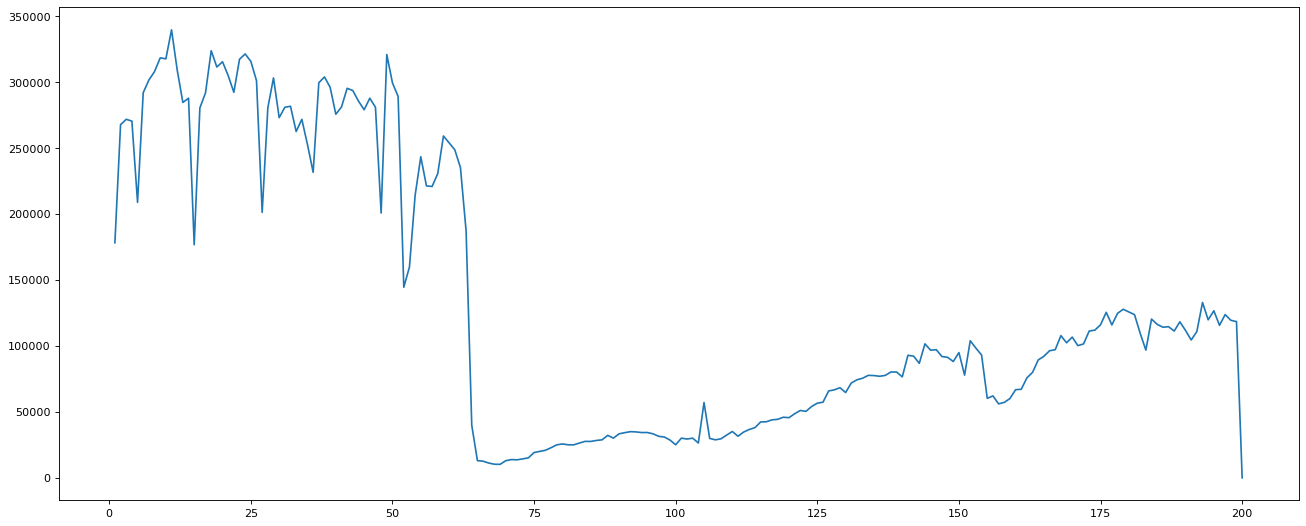

In [3]:
df["year"]=df["start"].dt.isocalendar().year
df["num_weeks"]=df["number of weeks"]+(df["year"]-2019)*52
count=df['num_weeks'].value_counts()
x=list(range(1,201))
count_week=[]
for i in range(1,201):
    count_week.append(count[i])
plt.figure(figsize=(20,8),dpi=80)
plt.plot(x,count_week)

In [4]:
count_area=df['Dropoff Community Area'].groupby(df['Pickup Community Area']).value_counts()

od_list=[] 
for i in range(1,78):
    for j in range(1,78):
        if (i,j) in count_area.index:
            if (count_area[i,j]>10000): #Filter out the OD pairs with the number of trips bigger than 10000
                od_list.append((i,j))


In [5]:
odtrips=[] 
max_weeks=max(df['num_weeks'])
for i in range(0,len(od_list)):   
    df_area=df[(df["Pickup Community Area"]==od_list[i][0])&(df["Dropoff Community Area"]==od_list[i][1])]
    count_area=df_area['num_weeks'].value_counts()
    #array=np.zeros(len(count_area))
    for j in range(1,max_weeks+1):
        if j in count_area.index:
            #array[j-1]=count_area[j]
            odtrips.append(count_area[j])
        else:
            odtrips.append(0)

s=int(len(odtrips)/max_weeks)
odtrips = np.mat(odtrips).reshape(s,max_weeks)
odtrips = np.array(odtrips)

#Normalization
odtrips=(odtrips-np.min(odtrips))/(np.max(odtrips)-np.min(odtrips))
odtrips #size 182x200

array([[0.00645928, 0.00831713, 0.00864118, ..., 0.00216029, 0.0021819 ,
        0.        ],
       [0.00326204, 0.00308922, 0.00330525, ..., 0.00116656, 0.00097213,
        0.        ],
       [0.00216029, 0.0014906 , 0.00190106, ..., 0.00090732, 0.00103694,
        0.        ],
       ...,
       [0.00321884, 0.00451501, 0.00479585, ..., 0.00362929, 0.00384532,
        0.        ],
       [0.00198747, 0.00317563, 0.00306762, ..., 0.002938  , 0.00224671,
        0.        ],
       [0.0147116 , 0.01777922, 0.01516526, ..., 0.00680493, 0.00652409,
        0.        ]])

In [6]:
import sys
from clustering import DTWClustering
from sklearn.model_selection import train_test_split
%matplotlib inline

In [7]:
data_train, data_test=train_test_split(odtrips,test_size=0.2,random_state=12)#80% train dataset and 20% test dataset
train_before=data_train[:,:60] #Before the Resistance
train_after=data_train[:,60:201] #After the Resistance
test_before=data_test[:,:60]  #Before the Resistance
test_after=data_test[:,60:201] #After the Resistance

In [52]:
model = DTWClustering(data_train, 5)
model.train()

0.0011627999997472216 queue placement complete
21.90822440000011 computations complete
21.909068599999955 iteration complete
0.0003750999999283522 queue placement complete
22.397899299999608 computations complete
22.398623699999916 iteration complete
0.00043310000000928994 queue placement complete
21.376378399999794 computations complete
21.377115700000104 iteration complete
0.0006425999999919441 queue placement complete
21.568654700000025 computations complete
21.569565699999657 iteration complete
0.0003689000000122178 queue placement complete
21.355671000000257 computations complete
21.35699169999998 iteration complete
0.0005193000001781911 queue placement complete
21.770867700000053 computations complete
21.77155300000004 iteration complete
0.00036019999970449135 queue placement complete
27.143711599999733 computations complete
27.144432600000073 iteration complete
0.0006222000001798733 queue placement complete
23.262070100000074 computations complete
23.26276280000002 iteration com

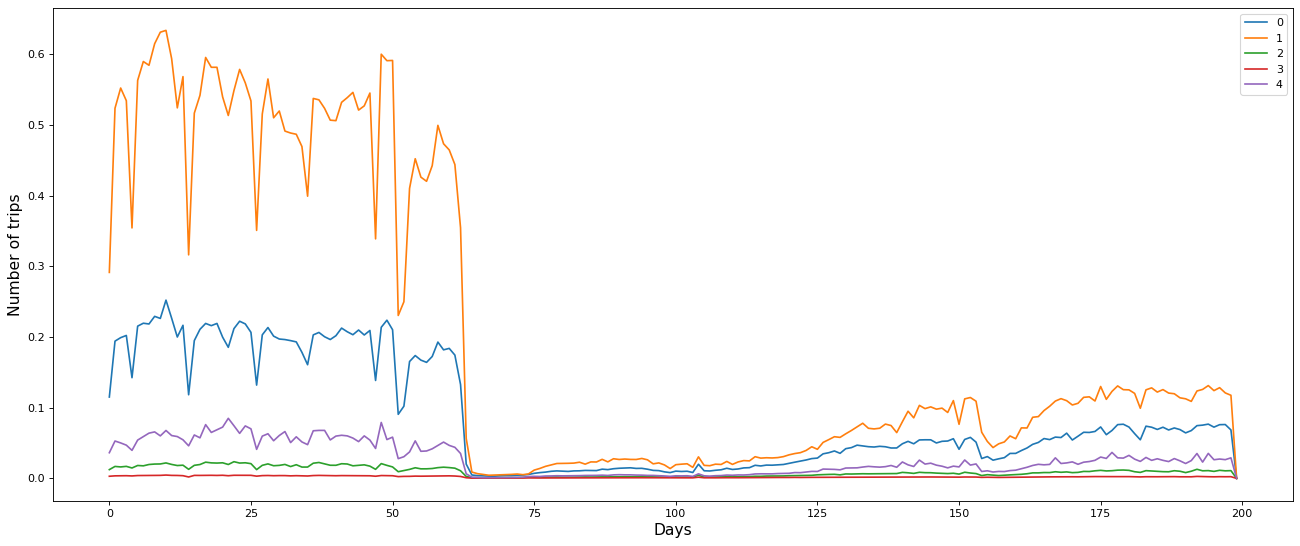

In [53]:
plt.figure(figsize=(20,8),dpi=80)
i=0
for centroid in model.centroids:
    plt.plot(np.arange(len(centroid)), centroid,label=i)
    plt.xlabel('Days',fontsize=14)
    plt.ylabel('Number of trips',fontsize=14)
    i=i+1
plt.legend() 

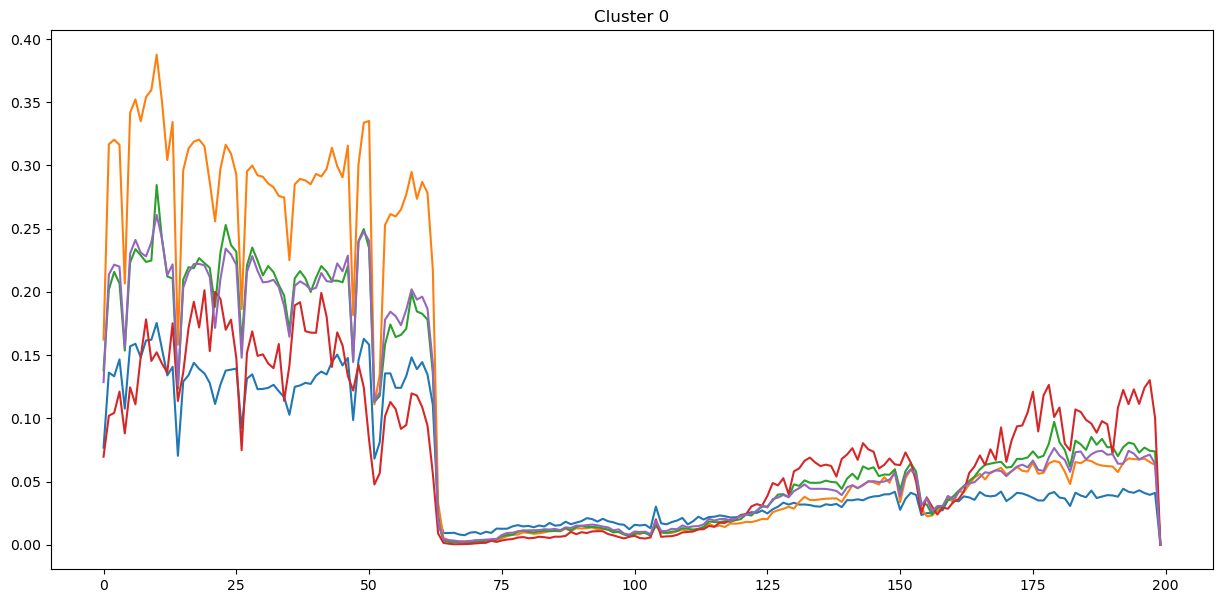

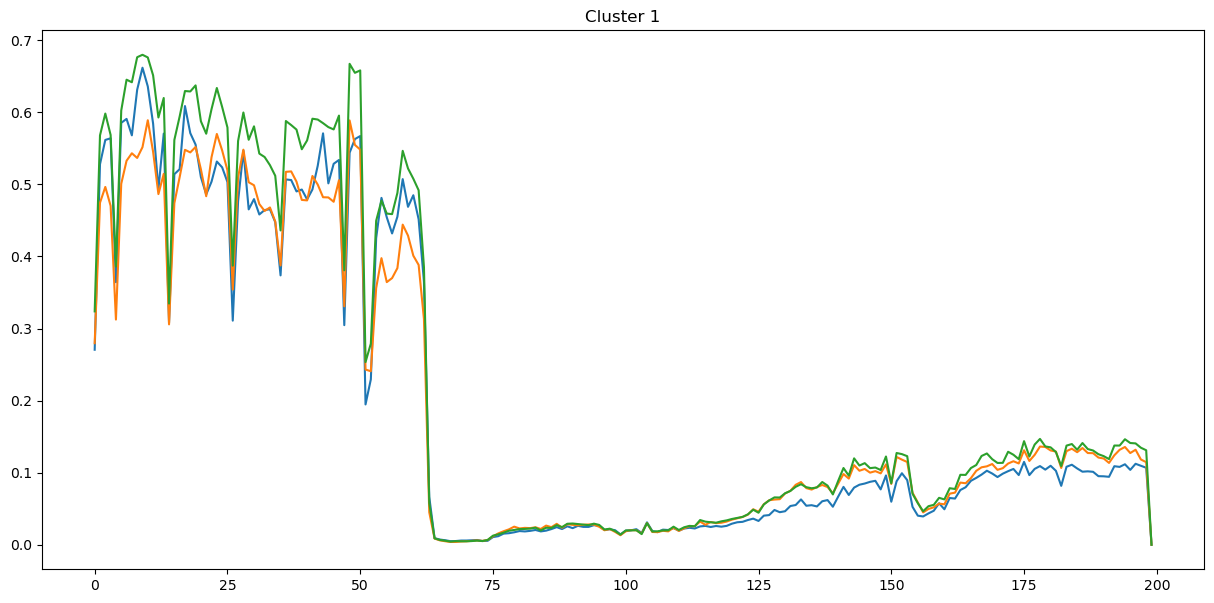

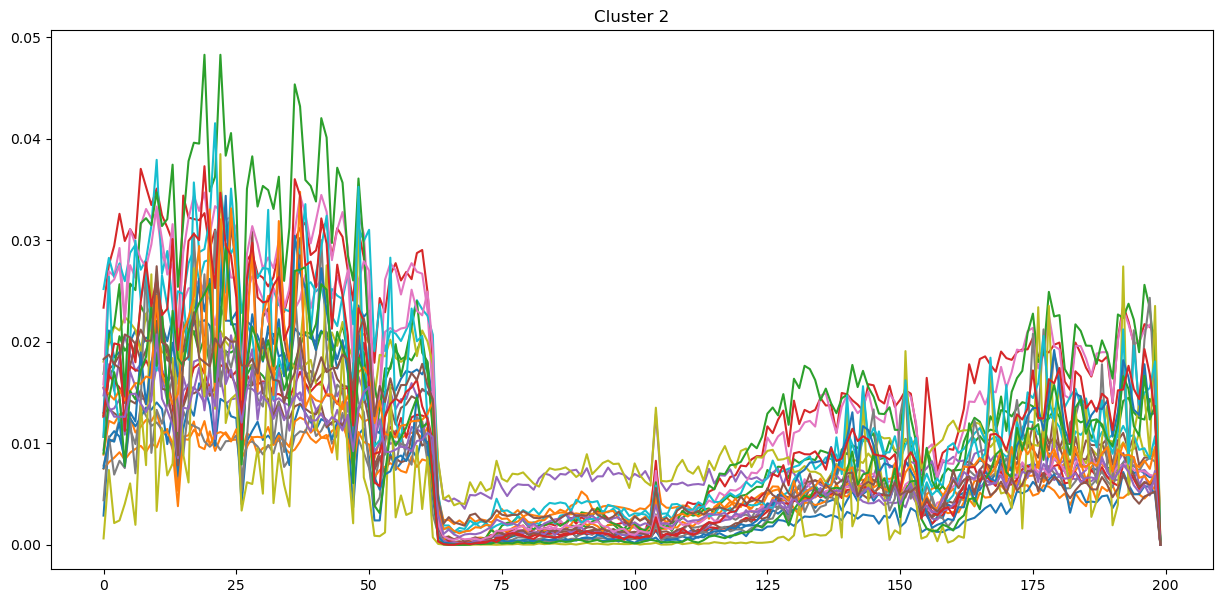

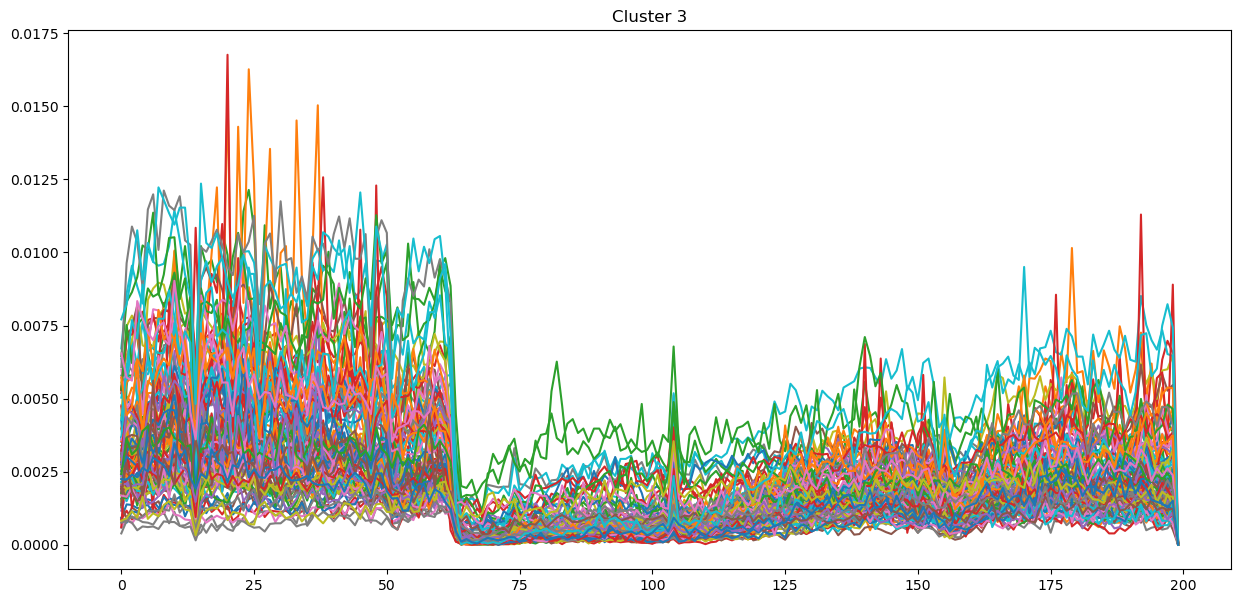

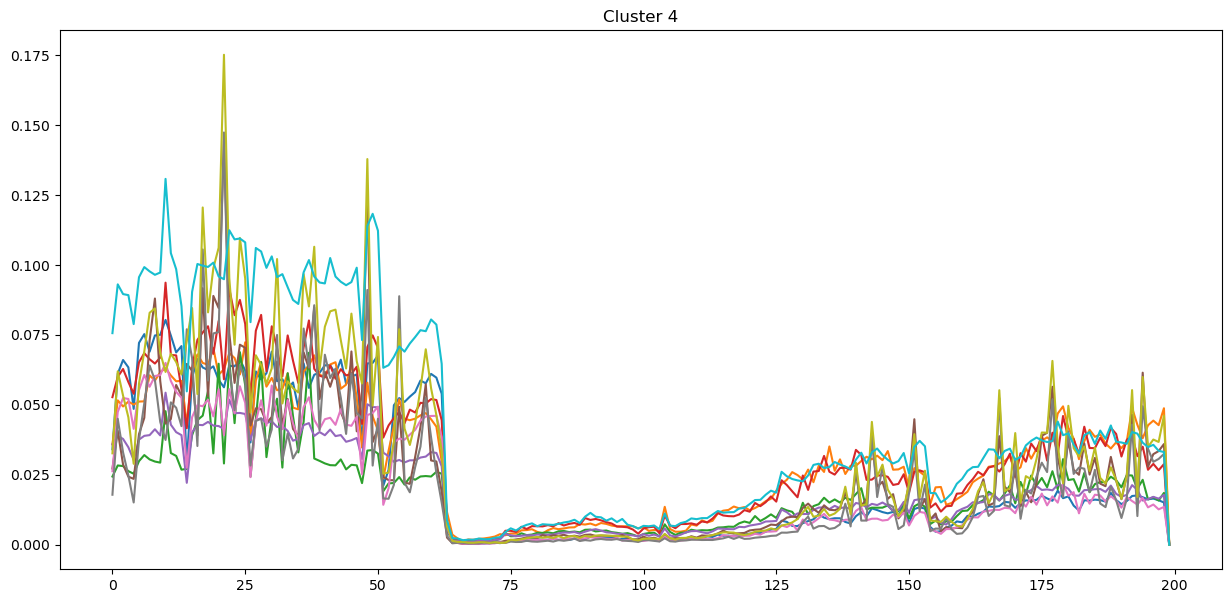

In [54]:
for j in range (5):
    plt.figure(figsize=(15,7))
    for i in model.clusters[j]:
        plt.title("Cluster %d"%j)
        plt.plot(np.arange(len(data_train[i])),data_train[i])

In [55]:
cluster_0=[]
cluster_1=[]
cluster_2=[]
cluster_3=[]
cluster_4=[]

for i in range(len(data_test)):
    if model.predict(data_test[i])[1]==0:
        cluster_0.append(i)
    elif model.predict(data_test[i])[1]==1:
        cluster_1.append(i)
    elif model.predict(data_test[i])[1]==2:
        cluster_2.append(i)
    elif model.predict(data_test[i])[1]==3:
        cluster_3.append(i)
    else:
        cluster_4.append(i)

##### Build a resilience model separately for a single cluster with train dataset

In [56]:
import torch
from scipy.optimize import curve_fit
from torch.optim import Adam
from torch import optim

In [57]:
def func(x,a,b,c,d):
    y=d/(1+torch.exp(a+b*x)+c)
    return y

In [99]:
#According to the epidemic prevention policy, the time interval is divided into six periods
#[59,68],[69,85],[94,103],[105,150],[151,155],[156,195]
time_interval=[[59,69],[69,94],[94,99],[99,151],[151,157],[157,180]]

## Cluster0

In [100]:
n=len(model.clusters[0])
yorigin=[]
xdays=[]
x_days=[]
ydata=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    sum_y=np.zeros([1,b-a+1])
    days=np.array(np.linspace(a, b,b-a+1))
    for j in model.clusters[0]:
        sum_y=sum_y+data_train[j][a:b+1]
    sum_y=sum_y/n
    yorigin.append(sum_y)
    xdays.append(days)
    x_days.append(days)
    ydata.append(sum_y)

Text(0.5, 0, 'weeks')

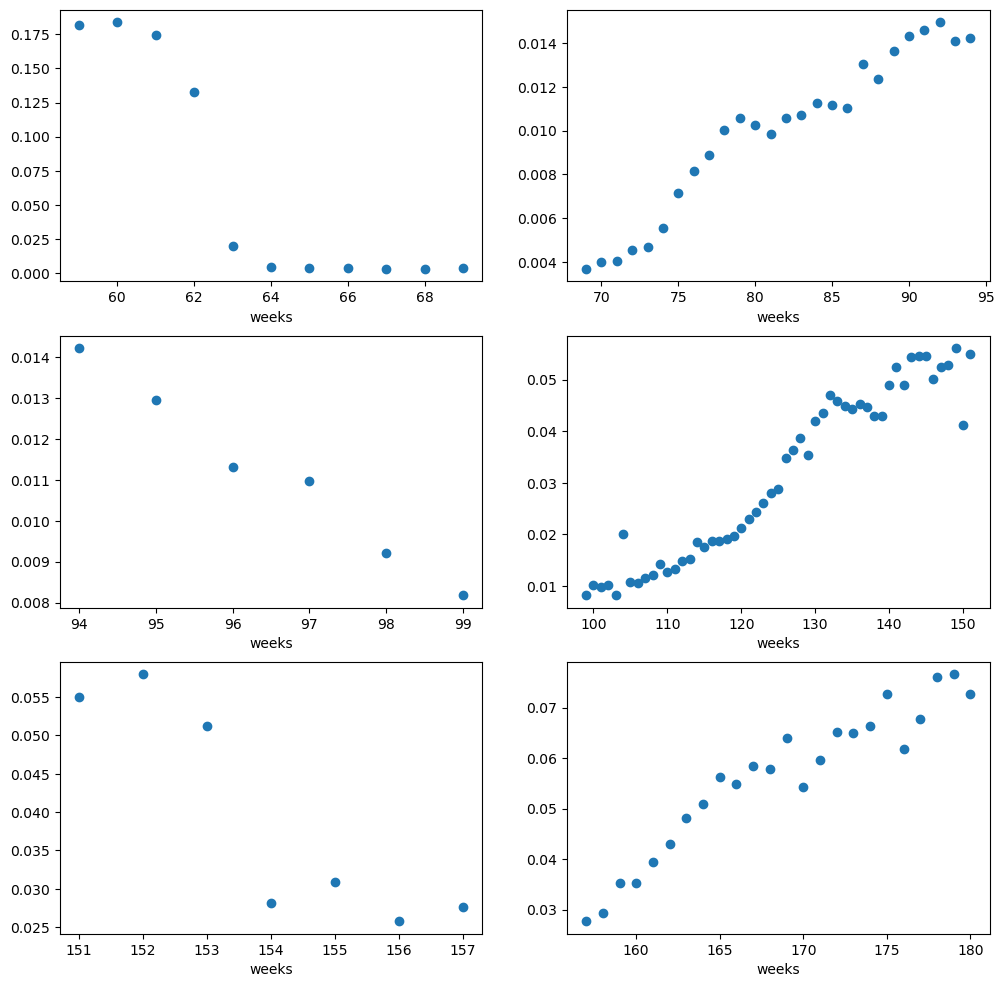

In [101]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
plt.subplot(3,2,1)
plt.scatter(xdays[0], yorigin[0])
plt.xlabel('weeks')
plt.subplot(3,2,2)
plt.scatter(xdays[1], yorigin[1])
plt.xlabel('weeks')
plt.subplot(3,2,3)
plt.scatter(xdays[2], yorigin[2])
plt.xlabel('weeks')
plt.subplot(3,2,4)
plt.scatter(xdays[3], yorigin[3])
plt.xlabel('weeks')
plt.subplot(3,2,5)
plt.scatter(xdays[4], yorigin[4])
plt.xlabel('weeks')
plt.subplot(3,2,6)
plt.scatter(xdays[5], yorigin[5])
plt.xlabel('weeks')

In [102]:
normality=np.zeros([1,60])
for i in model.clusters[0]:
    normality=normality+train_before[i]
normality=normality/len(model.clusters[0]) 
min_trips=np.min(yorigin[0]) #bottom of the resilience model (average of all data in cluster 0)
average_normality=np.mean(normality)

In [103]:
for i in range(len(time_interval)):
    ydata[i]=torch.tensor((yorigin[i]-min_trips)/(average_normality-min_trips))
    x_days[i]=torch.tensor((xdays[i]-np.min(xdays[i]))/(np.max(xdays[i])-np.min(xdays[i])))


Text(0.5, 0, 'weeks')

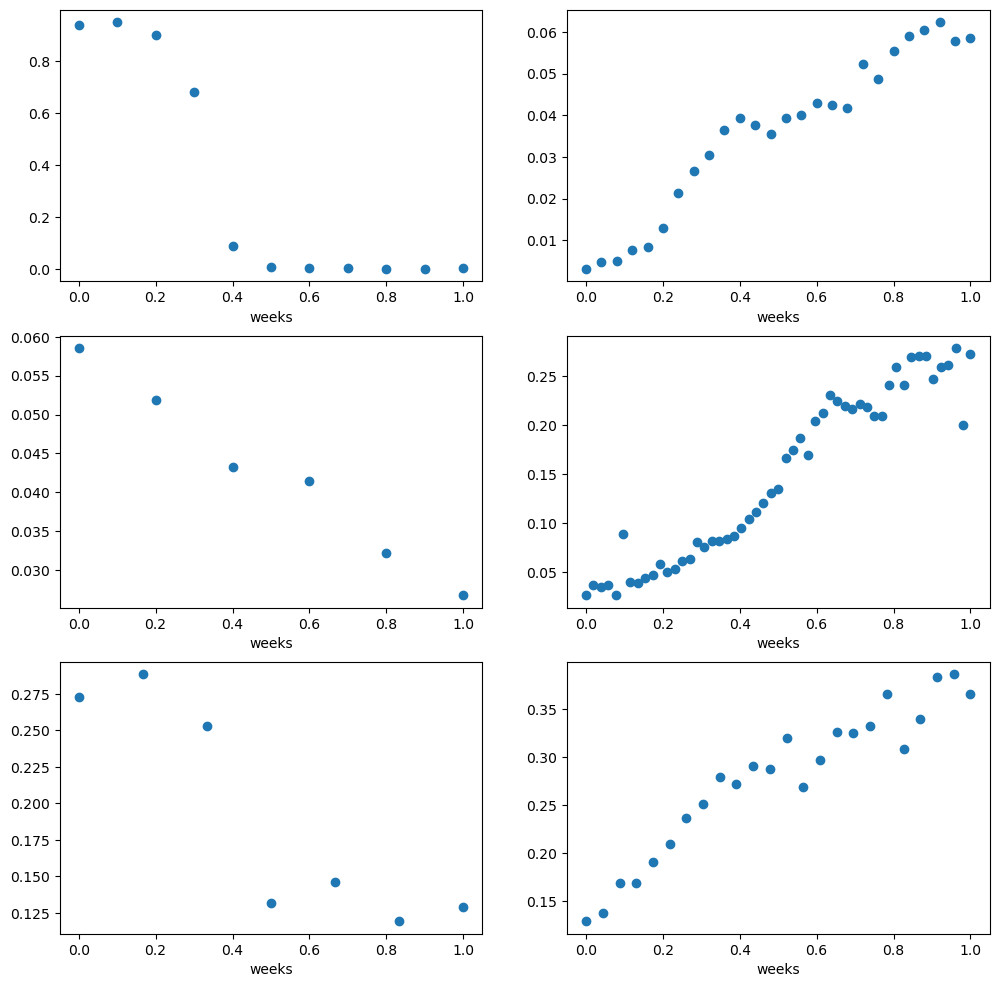

In [104]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
plt.subplot(3,2,1)
plt.scatter(x_days[0], ydata[0])
plt.xlabel('weeks')
plt.subplot(3,2,2)
plt.scatter(x_days[1], ydata[1])
plt.xlabel('weeks')
plt.subplot(3,2,3)
plt.scatter(x_days[2], ydata[2])
plt.xlabel('weeks')
plt.subplot(3,2,4)
plt.scatter(x_days[3], ydata[3])
plt.xlabel('weeks')
plt.subplot(3,2,5)
plt.scatter(x_days[4], ydata[4])
plt.xlabel('weeks')
plt.subplot(3,2,6)
plt.scatter(x_days[5], ydata[5])
plt.xlabel('weeks')


In [105]:
parameter=[]
predict=[]
for k in range(len(time_interval)):
    print("%s"%k)
    device="cpu"
    a = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    b = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    c = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    d = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    params=[a,b,c,d]
    optimizer = optim.Adam(params,lr=0.002)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer,gamma=0.8,step_size=5000)

    for i in range(20000):
        optimizer.zero_grad()
        predict_y = func(x_days[k],*params)
        loss = torch.mean(torch.pow(ydata[k]-predict_y,2))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        if i%1000==0:
            print("step=%s loss=%.5f"%(i,loss))
    pre_y = func(x_days[k],*params)
    parameter.append(params)
    predict.append(pre_y)

0
step=0 loss=0.53423
step=1000 loss=0.13578
step=2000 loss=0.02875
step=3000 loss=0.02476
step=4000 loss=0.02018
step=5000 loss=0.01593
step=6000 loss=0.01299
step=7000 loss=0.01050
step=8000 loss=0.00846
step=9000 loss=0.00680
step=10000 loss=0.00546
step=11000 loss=0.00456
step=12000 loss=0.00379
step=13000 loss=0.00313
step=14000 loss=0.00258
step=15000 loss=0.00211
step=16000 loss=0.00178
step=17000 loss=0.00149
step=18000 loss=0.00124
step=19000 loss=0.00102
1
step=0 loss=0.00549
step=1000 loss=0.00037
step=2000 loss=0.00021
step=3000 loss=0.00011
step=4000 loss=0.00004
step=5000 loss=0.00004
step=6000 loss=0.00003
step=7000 loss=0.00003
step=8000 loss=0.00002
step=9000 loss=0.00002
step=10000 loss=0.00002
step=11000 loss=0.00002
step=12000 loss=0.00002
step=13000 loss=0.00002
step=14000 loss=0.00002
step=15000 loss=0.00002
step=16000 loss=0.00002
step=17000 loss=0.00002
step=18000 loss=0.00002
step=19000 loss=0.00002
2
step=0 loss=0.07154
step=1000 loss=0.00011
step=2000 loss=0.

Text(0.5, 0, 'weeks')

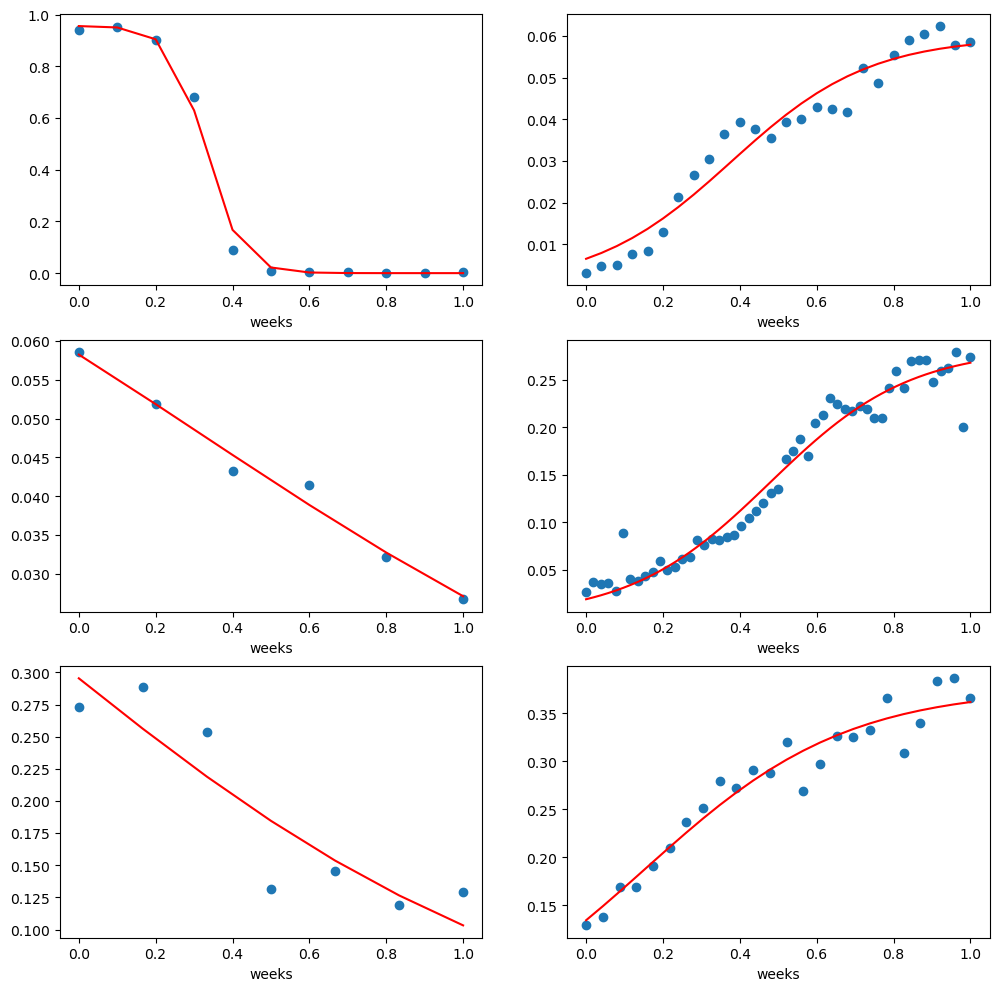

In [106]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
plt.subplot(3,2,1)
plt.scatter(x_days[0], ydata[0], label='[59,70]')
plt.plot(x_days[0], predict[0].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,2)
plt.scatter(x_days[1], ydata[1], label='[70,92]')
plt.plot(x_days[1], predict[1].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,3)
plt.scatter(x_days[2], ydata[2], label='[93,103]')
plt.plot(x_days[2], predict[2].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,4)
plt.scatter(x_days[3], ydata[3], label='[105,150]')
plt.plot(x_days[3], predict[3].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,5)
plt.scatter(x_days[4], ydata[4], label='[151,156]')
plt.plot(x_days[4], predict[4].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,6)
plt.scatter(x_days[5], ydata[5], label='[157,180]')
plt.plot(x_days[5], predict[5].detach().numpy(), 'r-')
plt.xlabel('weeks')

#### data recovery

In [107]:
y_predict=[]
for i in range(len(time_interval)):
    pre_y=predict[i]*(average_normality-min_trips)+min_trips
    y_predict.append(pre_y)

Text(0.5, 0, 'weeks')

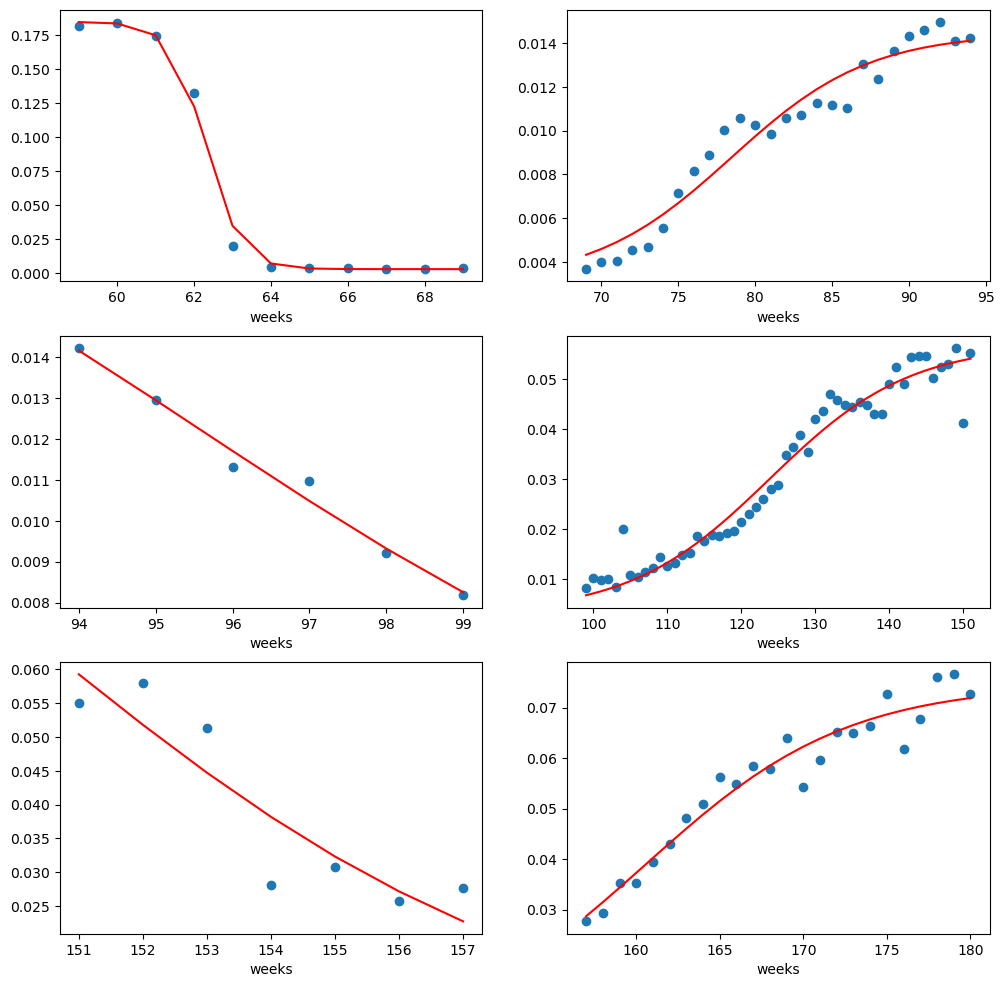

In [108]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
plt.subplot(3,2,1)
plt.scatter(xdays[0], yorigin[0], label='[59,70]')
plt.plot(xdays[0], y_predict[0].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,2)
plt.scatter(xdays[1], yorigin[1], label='[70,92]')
plt.plot(xdays[1], y_predict[1].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,3)
plt.scatter(xdays[2], yorigin[2], label='[93,103]')
plt.plot(xdays[2], y_predict[2].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,4)
plt.scatter(xdays[3], yorigin[3], label='[105,150]')
plt.plot(xdays[3], y_predict[3].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,5)
plt.scatter(xdays[4], yorigin[4], label='[151,156]')
plt.plot(xdays[4], y_predict[4].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,6)
plt.scatter(xdays[5], yorigin[5], label='[157,180]')
plt.plot(xdays[5], y_predict[5].detach().numpy(), 'r-')
plt.xlabel('weeks')

## Predict

In [109]:
cluster_0

[22]

In [110]:
predict22=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    y=data_test[22][a:b+1]
    pre_y=predict[i]*(np.mean(test_before[22])-min_trips)+min_trips
    if i>0:
        pre_y[0]=predict22[i-1][-1]
    predict22.append(pre_y)


Text(0, 0.5, 'Number of trips')

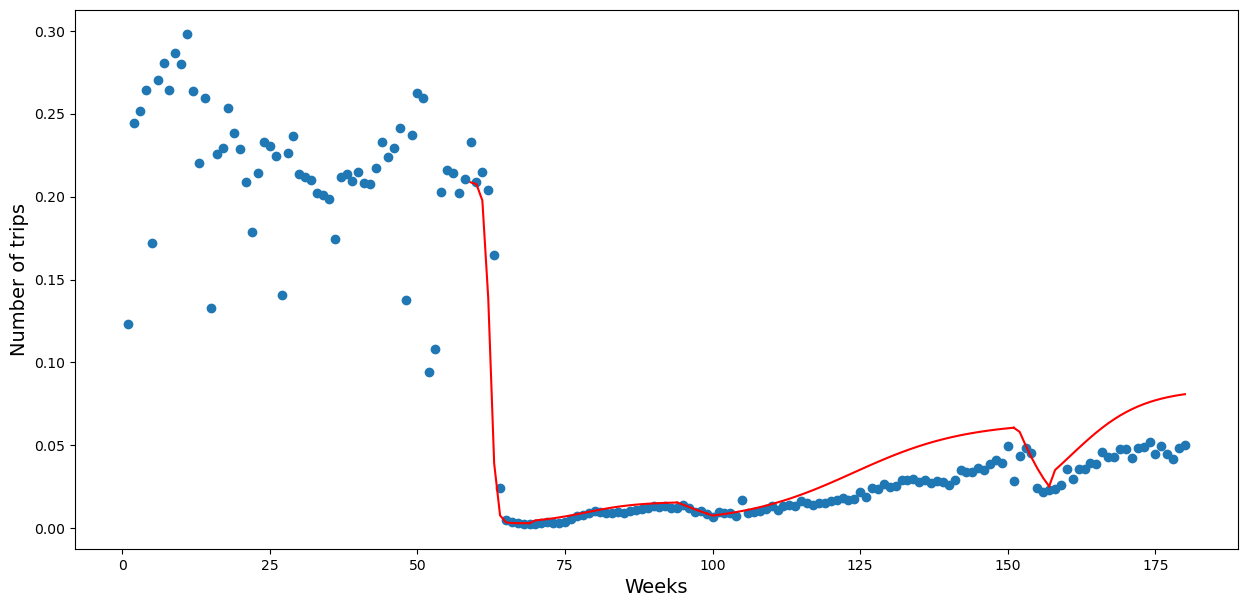

In [111]:
plt.figure(figsize=(15,7))
plt.scatter(np.linspace(1, 180,180), data_test[22][:180],label='real_data')
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    plt.plot(np.linspace(a, b,b-a+1), predict22[i].detach().numpy(),'r')
plt.xlabel('Weeks',fontsize=14)
plt.ylabel('Number of trips',fontsize=14)
#plt.legend()

## Cluster1

In [150]:
n=len(model.clusters[1])
yorigin=[]
xdays=[]
x_days=[]
ydata=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    sum_y=np.zeros([1,b-a+1])
    days=np.array(np.linspace(a, b,b-a+1))
    for j in model.clusters[1]:
        sum_y=sum_y+data_train[j][a:b+1]
    sum_y=sum_y/n
    yorigin.append(sum_y)
    xdays.append(days)
    x_days.append(days)
    ydata.append(sum_y)

In [151]:
normality=np.zeros([1,60])
for i in model.clusters[1]:
    normality=normality+train_before[i]
normality=normality/len(model.clusters[1]) 
min_trips=np.min(yorigin[0]) #bottom of the resilience model (average of all data in cluster 0)
average_normality=np.mean(normality)

for i in range(len(time_interval)):
    ydata[i]=torch.tensor((yorigin[i]-min_trips)/(average_normality-min_trips))
    x_days[i]=torch.tensor((xdays[i]-np.min(xdays[i]))/(np.max(xdays[i])-np.min(xdays[i])))

In [152]:
parameter=[]
predict=[]
for k in range(len(time_interval)):
    print("%s"%k)
    device="cpu"
    a = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    b = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    c = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    d = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    params=[a,b,c,d]
    optimizer = optim.Adam(params,lr=0.002)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer,gamma=0.8,step_size=5000)

    for i in range(20000):
        optimizer.zero_grad()
        predict_y = func(x_days[k],*params)
        loss = torch.mean(torch.pow(ydata[k]-predict_y,2))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        if i%1000==0:
            print("step=%s loss=%.5f"%(i,loss))
    pre_y = func(x_days[k],*params)
    parameter.append(params)
    predict.append(pre_y)

0
step=0 loss=0.20117
step=1000 loss=0.03707
step=2000 loss=0.03322
step=3000 loss=0.02822
step=4000 loss=0.02271
step=5000 loss=0.01789
step=6000 loss=0.01466
step=7000 loss=0.01194
step=8000 loss=0.00970
step=9000 loss=0.00787
step=10000 loss=0.00639
step=11000 loss=0.00539
step=12000 loss=0.00452
step=13000 loss=0.00378
step=14000 loss=0.00315
step=15000 loss=0.00261
step=16000 loss=0.00223
step=17000 loss=0.00190
step=18000 loss=0.00161
step=19000 loss=0.00135
1
step=0 loss=0.01525
step=1000 loss=0.00026
step=2000 loss=0.00026
step=3000 loss=0.00026
step=4000 loss=0.00024
step=5000 loss=0.00012
step=6000 loss=0.00003
step=7000 loss=0.00002
step=8000 loss=0.00002
step=9000 loss=0.00002
step=10000 loss=0.00001
step=11000 loss=0.00001
step=12000 loss=0.00001
step=13000 loss=0.00001
step=14000 loss=0.00001
step=15000 loss=0.00001
step=16000 loss=0.00001
step=17000 loss=0.00001
step=18000 loss=0.00001
step=19000 loss=0.00001
2
step=0 loss=0.05539
step=1000 loss=0.00043
step=2000 loss=0.

Text(0.5, 0, 'weeks')

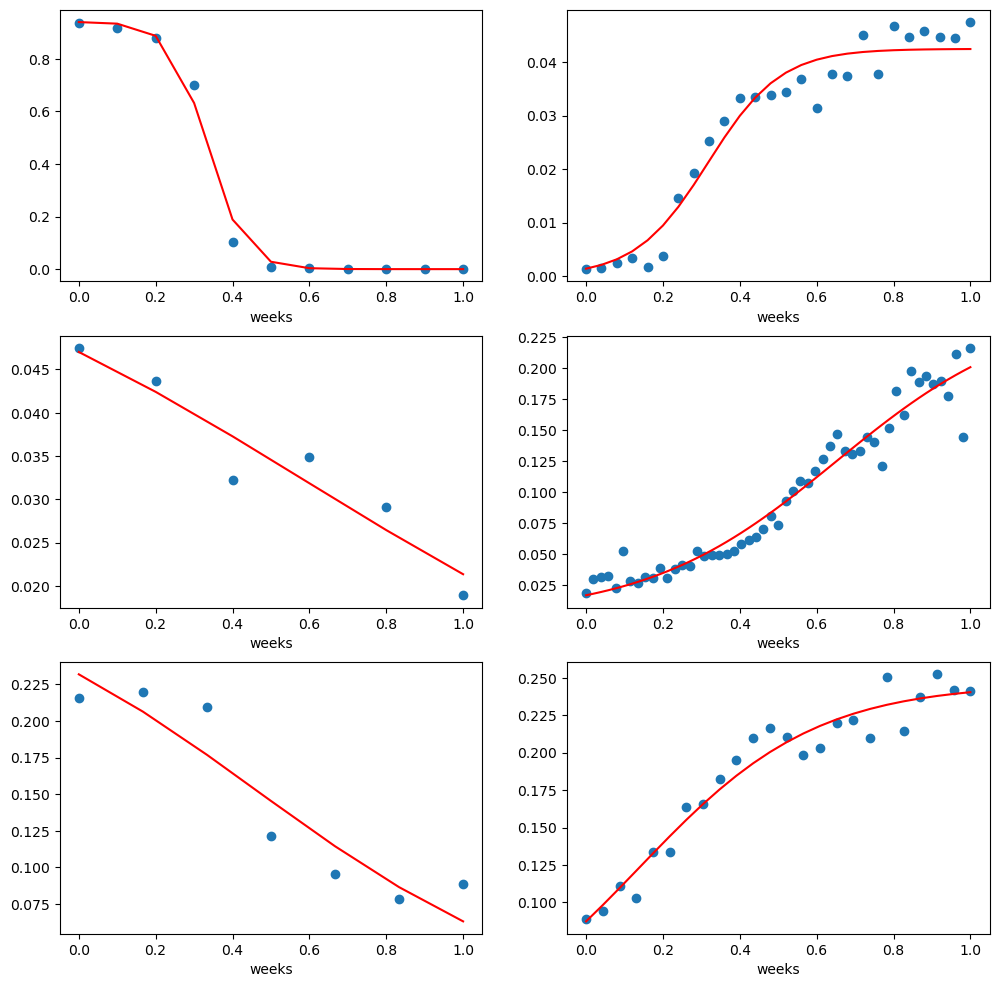

In [153]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
plt.subplot(3,2,1)
plt.scatter(x_days[0], ydata[0], label='[59,70]')
plt.plot(x_days[0], predict[0].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,2)
plt.scatter(x_days[1], ydata[1], label='[70,92]')
plt.plot(x_days[1], predict[1].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,3)
plt.scatter(x_days[2], ydata[2], label='[93,103]')
plt.plot(x_days[2], predict[2].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,4)
plt.scatter(x_days[3], ydata[3], label='[105,150]')
plt.plot(x_days[3], predict[3].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,5)
plt.scatter(x_days[4], ydata[4], label='[151,156]')
plt.plot(x_days[4], predict[4].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,6)
plt.scatter(x_days[5], ydata[5], label='[157,180]')
plt.plot(x_days[5], predict[5].detach().numpy(), 'r-')
plt.xlabel('weeks')

In [154]:
cluster_1

[9]

In [155]:
predict9=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    pre_y=predict[i]*(np.mean(test_before[9])-min_trips)+min_trips
    if i>0:
        pre_y[0]=predict9[i-1][-1]
    predict9.append(pre_y)

Text(0, 0.5, 'Number of trips')

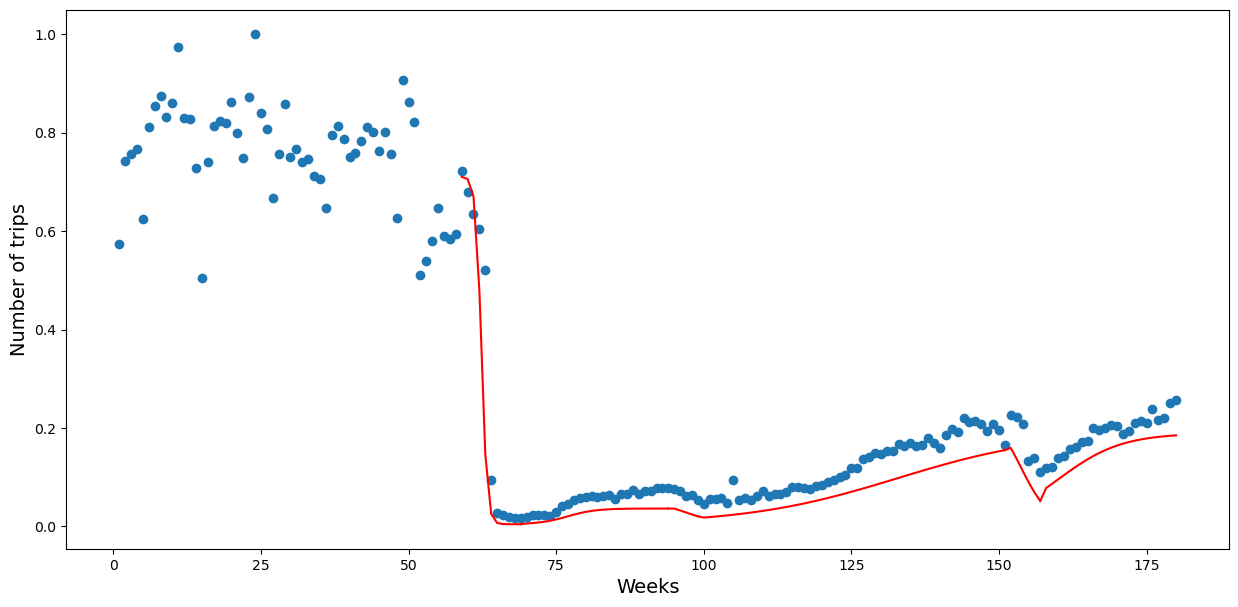

In [156]:
plt.figure(figsize=(15,7))
plt.scatter(np.linspace(1, 180,180), data_test[9][:180],label='real_data')
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    plt.plot(np.linspace(a, b,b-a+1), predict9[i].detach().numpy(),'r')
plt.xlabel('Weeks',fontsize=14)
plt.ylabel('Number of trips',fontsize=14)
#plt.legend()

## Cluster2

In [119]:
n=len(model.clusters[2])
yorigin=[]
xdays=[]
x_days=[]
ydata=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    sum_y=np.zeros([1,b-a+1])
    days=np.array(np.linspace(a, b,b-a+1))
    for j in model.clusters[2]:
        sum_y=sum_y+data_train[j][a:b+1]
    sum_y=sum_y/n
    yorigin.append(sum_y)
    xdays.append(days)
    x_days.append(days)
    ydata.append(sum_y)
    
normality=np.zeros([1,60])
for i in model.clusters[2]:
    normality=normality+train_before[i]
normality=normality/len(model.clusters[2]) 
min_trips=np.min(yorigin[0]) #bottom of the resilience model (average of all data in cluster 0)
average_normality=np.mean(normality)

for i in range(len(time_interval)):
    ydata[i]=torch.tensor((yorigin[i]-min_trips)/(average_normality-min_trips))
    x_days[i]=torch.tensor((xdays[i]-np.min(xdays[i]))/(np.max(xdays[i])-np.min(xdays[i])))

In [120]:
parameter=[]
predict=[]
for k in range(len(time_interval)):
    print("%s"%k)
    device="cpu"
    a = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    b = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    c = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    d = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    params=[a,b,c,d]
    optimizer = optim.Adam(params,lr=0.001)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer,gamma=0.8,step_size=5000)

    for i in range(20000):
        optimizer.zero_grad()
        predict_y = func(x_days[k],*params)
        loss = torch.mean(torch.pow(ydata[k]-predict_y,2))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        if i%1000==0:
            print("step=%s loss=%.5f"%(i,loss))
    pre_y = func(x_days[k],*params)
    parameter.append(params)
    predict.append(pre_y)

0
step=0 loss=0.18104
step=1000 loss=0.10450
step=2000 loss=0.04535
step=3000 loss=0.02241
step=4000 loss=0.02003
step=5000 loss=0.01870
step=6000 loss=0.01717
step=7000 loss=0.01525
step=8000 loss=0.01327
step=9000 loss=0.01146
step=10000 loss=0.00987
step=11000 loss=0.00875
step=12000 loss=0.00775
step=13000 loss=0.00686
step=14000 loss=0.00606
step=15000 loss=0.00536
step=16000 loss=0.00485
step=17000 loss=0.00439
step=18000 loss=0.00396
step=19000 loss=0.00357
1
step=0 loss=0.00885
step=1000 loss=0.00049
step=2000 loss=0.00023
step=3000 loss=0.00010
step=4000 loss=0.00009
step=5000 loss=0.00009
step=6000 loss=0.00008
step=7000 loss=0.00008
step=8000 loss=0.00007
step=9000 loss=0.00006
step=10000 loss=0.00006
step=11000 loss=0.00006
step=12000 loss=0.00006
step=13000 loss=0.00006
step=14000 loss=0.00006
step=15000 loss=0.00006
step=16000 loss=0.00006
step=17000 loss=0.00006
step=18000 loss=0.00006
step=19000 loss=0.00006
2
step=0 loss=0.35715
step=1000 loss=0.03980
step=2000 loss=0.

Text(0.5, 0, 'weeks')

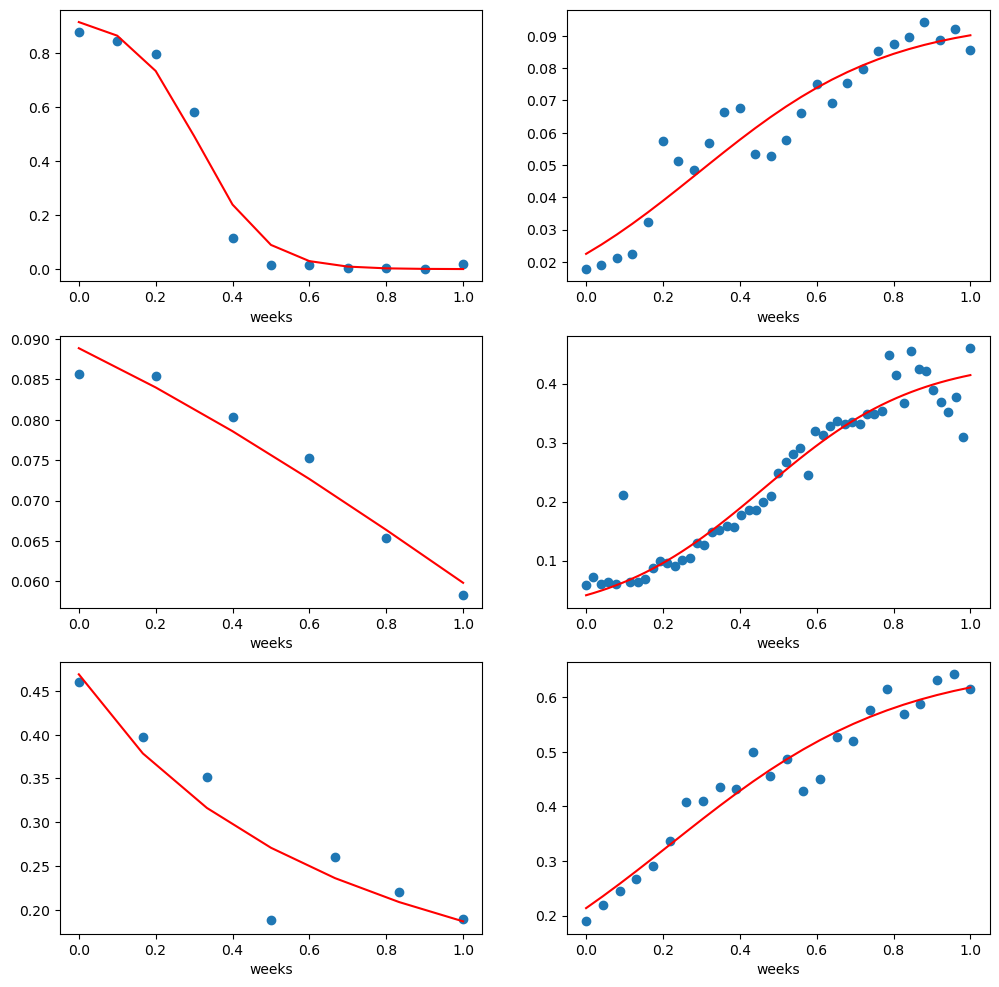

In [121]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
plt.subplot(3,2,1)
plt.scatter(x_days[0], ydata[0], label='[59,70]')
plt.plot(x_days[0], predict[0].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,2)
plt.scatter(x_days[1], ydata[1], label='[70,92]')
plt.plot(x_days[1], predict[1].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,3)
plt.scatter(x_days[2], ydata[2], label='[93,103]')
plt.plot(x_days[2], predict[2].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,4)
plt.scatter(x_days[3], ydata[3], label='[105,150]')
plt.plot(x_days[3], predict[3].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,5)
plt.scatter(x_days[4], ydata[4], label='[151,156]')
plt.plot(x_days[4], predict[4].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,6)
plt.scatter(x_days[5], ydata[5], label='[157,180]')
plt.plot(x_days[5], predict[5].detach().numpy(), 'r-')
plt.xlabel('weeks')

In [82]:
cluster_2

[3, 10, 12, 14, 17, 21, 36]

In [122]:
predict12=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    pre_y=predict[i]*(np.mean(test_before[12])-min_trips)+min_trips
    if i>0:
        pre_y[0]=predict12[i-1][-1]
    predict12.append(pre_y)

Text(0, 0.5, 'Number of trips')

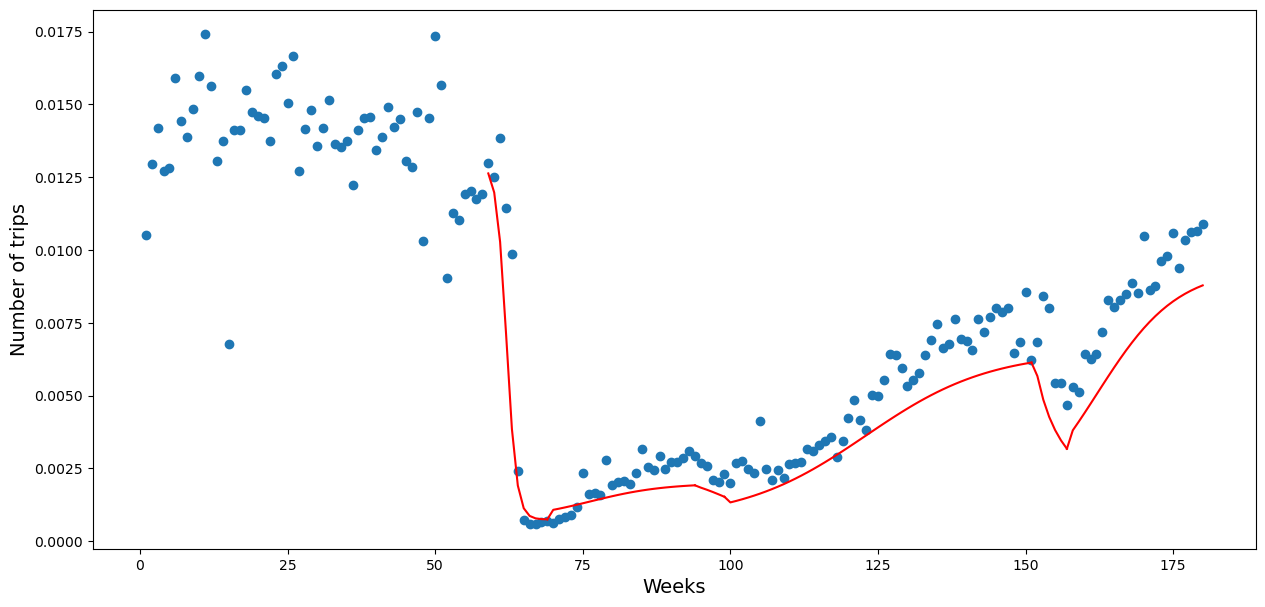

In [123]:
plt.figure(figsize=(15,7))
plt.scatter(np.linspace(1, 180,180), data_test[12][:180],label='real_data')
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    plt.plot(np.linspace(a, b,b-a+1), predict12[i].detach().numpy(),'r')
plt.xlabel('Weeks',fontsize=14)
plt.ylabel('Number of trips',fontsize=14)

In [124]:
predict21=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    pre_y=predict[i]*(np.mean(test_before[21])-min_trips)+min_trips
    if i>0:
        pre_y[0]=predict21[i-1][-1]
    predict21.append(pre_y)

Text(0, 0.5, 'Number of trips')

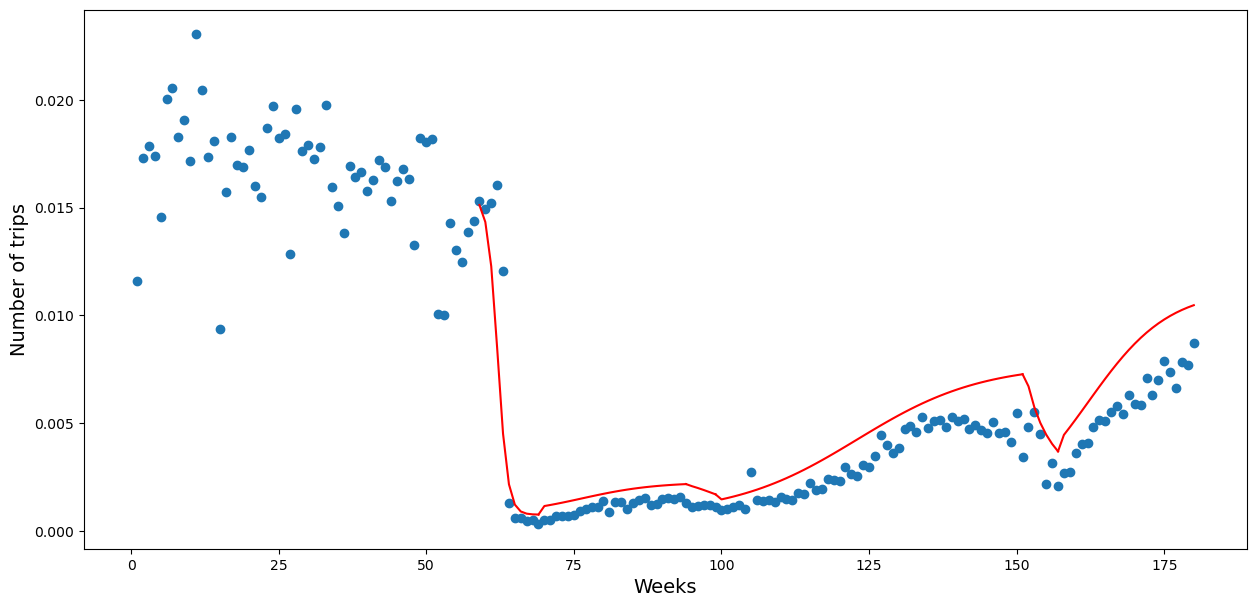

In [125]:
plt.figure(figsize=(15,7))
plt.scatter(np.linspace(1, 180,180), data_test[21][:180],label='real_data')
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    plt.plot(np.linspace(a, b,b-a+1), predict21[i].detach().numpy(),'r')
plt.xlabel('Weeks',fontsize=14)
plt.ylabel('Number of trips',fontsize=14)

## Cluster3

In [157]:
n=len(model.clusters[3])
yorigin=[]
xdays=[]
x_days=[]
ydata=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    sum_y=np.zeros([1,b-a+1])
    days=np.array(np.linspace(a, b,b-a+1))
    for j in model.clusters[3]:
        sum_y=sum_y+data_train[j][a:b+1]
    sum_y=sum_y/n
    yorigin.append(sum_y)
    xdays.append(days)
    x_days.append(days)
    ydata.append(sum_y)
    
normality=np.zeros([1,60])
for i in model.clusters[3]:
    normality=normality+train_before[i]
normality=normality/len(model.clusters[3]) 
min_trips=np.min(yorigin[0]) #bottom of the resilience model (average of all data in cluster 0)
average_normality=np.mean(normality)

for i in range(len(time_interval)):
    ydata[i]=torch.tensor((yorigin[i]-min_trips)/(average_normality-min_trips))
    x_days[i]=torch.tensor((xdays[i]-np.min(xdays[i]))/(np.max(xdays[i])-np.min(xdays[i])))

In [158]:
parameter=[]
predict=[]
for k in range(len(time_interval)):
    print("%s"%k)
    device="cpu"
    a = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    b = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    c = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    d = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    params=[a,b,c,d]
    optimizer = optim.Adam(params,lr=0.002)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer,gamma=0.8,step_size=5000)

    for i in range(20000):
        optimizer.zero_grad()
        predict_y = func(x_days[k],*params)
        loss = torch.mean(torch.pow(ydata[k]-predict_y,2))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        if i%1000==0:
            print("step=%s loss=%.5f"%(i,loss))
    pre_y = func(x_days[k],*params)
    parameter.append(params)
    predict.append(pre_y)

0
step=0 loss=0.76773
step=1000 loss=0.03699
step=2000 loss=0.03313
step=3000 loss=0.02974
step=4000 loss=0.02488
step=5000 loss=0.01918
step=6000 loss=0.01487
step=7000 loss=0.01132
step=8000 loss=0.00862
step=9000 loss=0.00660
step=10000 loss=0.00507
step=11000 loss=0.00410
step=12000 loss=0.00330
step=13000 loss=0.00264
step=14000 loss=0.00211
step=15000 loss=0.00168
step=16000 loss=0.00140
step=17000 loss=0.00115
step=18000 loss=0.00095
step=19000 loss=0.00078
1
step=0 loss=0.13298
step=1000 loss=0.01323
step=2000 loss=0.00101
step=3000 loss=0.00066
step=4000 loss=0.00041
step=5000 loss=0.00029
step=6000 loss=0.00026
step=7000 loss=0.00025
step=8000 loss=0.00022
step=9000 loss=0.00019
step=10000 loss=0.00016
step=11000 loss=0.00014
step=12000 loss=0.00013
step=13000 loss=0.00012
step=14000 loss=0.00012
step=15000 loss=0.00012
step=16000 loss=0.00012
step=17000 loss=0.00012
step=18000 loss=0.00012
step=19000 loss=0.00012
2
step=0 loss=0.13573
step=1000 loss=0.00205
step=2000 loss=0.

Text(0.5, 0, 'weeks')

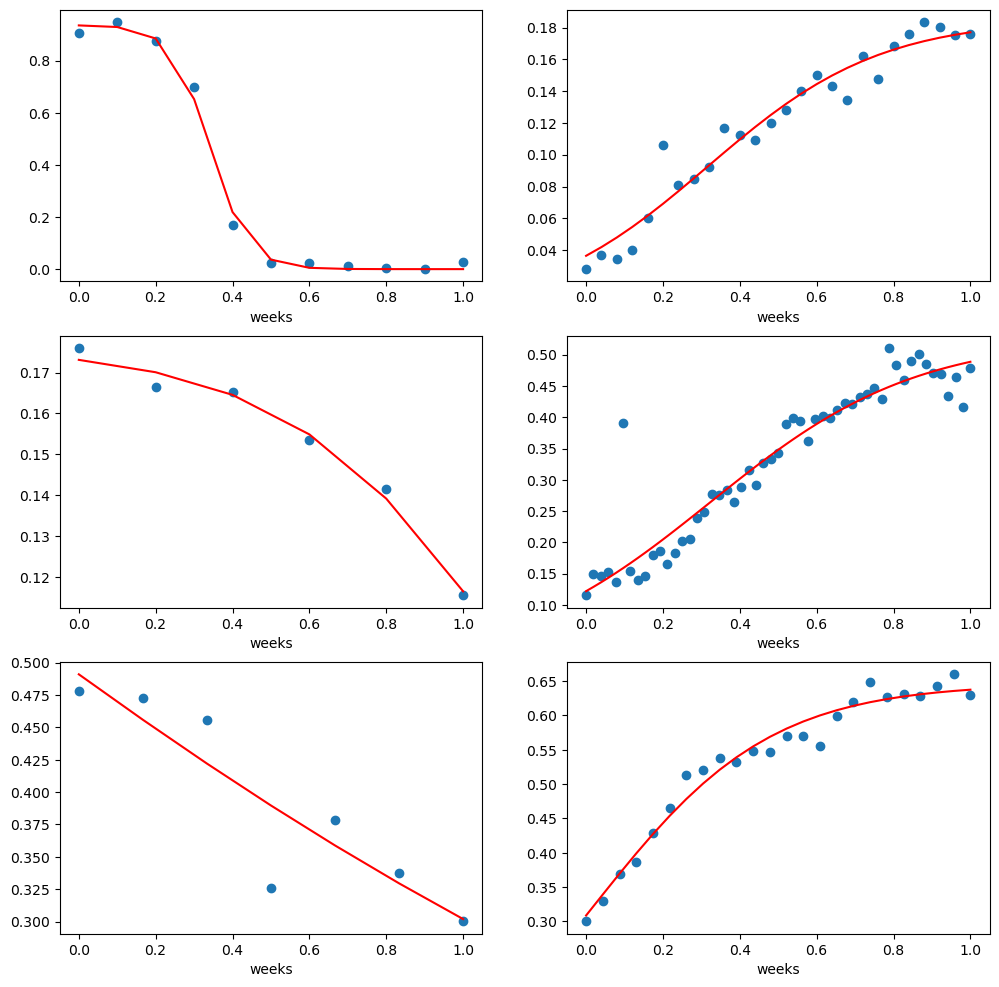

In [159]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
plt.subplot(3,2,1)
plt.scatter(x_days[0], ydata[0], label='[59,70]')
plt.plot(x_days[0], predict[0].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,2)
plt.scatter(x_days[1], ydata[1], label='[70,92]')
plt.plot(x_days[1], predict[1].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,3)
plt.scatter(x_days[2], ydata[2], label='[93,103]')
plt.plot(x_days[2], predict[2].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,4)
plt.scatter(x_days[3], ydata[3], label='[105,150]')
plt.plot(x_days[3], predict[3].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,5)
plt.scatter(x_days[4], ydata[4], label='[151,156]')
plt.plot(x_days[4], predict[4].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,6)
plt.scatter(x_days[5], ydata[5], label='[157,180]')
plt.plot(x_days[5], predict[5].detach().numpy(), 'r-')
plt.xlabel('weeks')

In [160]:
cluster_3

[0, 1, 4, 5, 6, 7, 8, 13, 15, 16, 19, 20, 23, 24, 25, 27, 28, 30, 32, 34, 35]

In [163]:
predict6=[]
min_trips=np.min(data_test[6][60:75])
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    pre_y=predict[i]*(np.mean(test_before[6])-min_trips)+min_trips
    if i>0:
        pre_y[0]=predict6[i-1][-1]
    predict6.append(pre_y)

Text(0, 0.5, 'Number of trips')

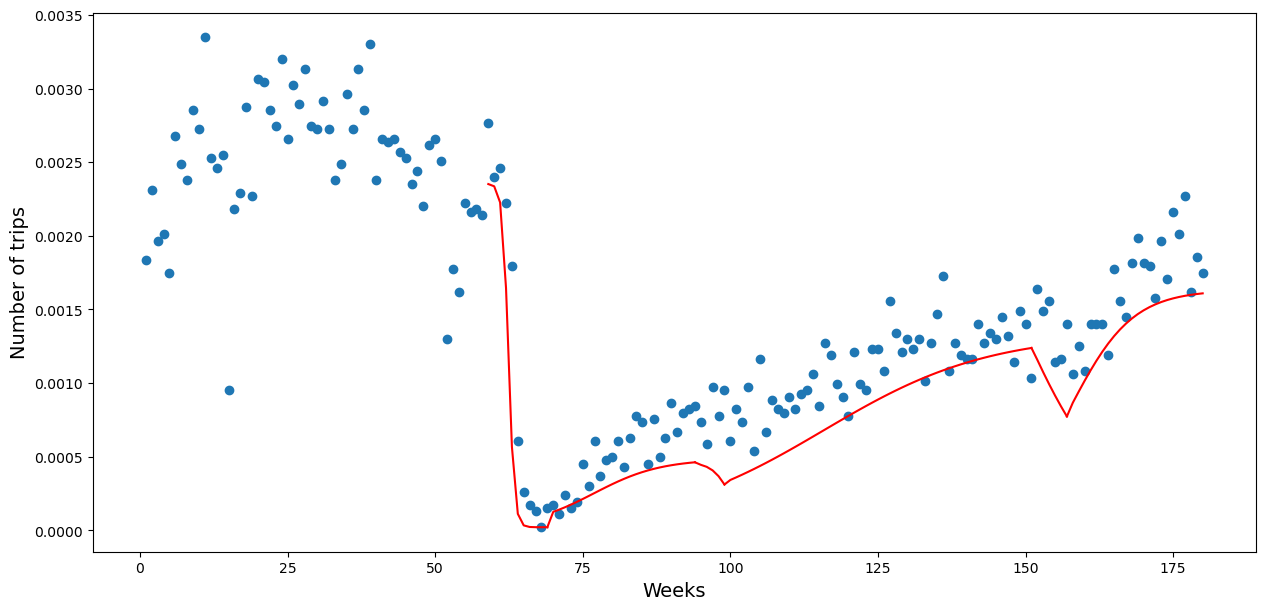

In [164]:
plt.figure(figsize=(15,7))
plt.scatter(np.linspace(1, 180,180), data_test[6][:180],label='real_data')
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    plt.plot(np.linspace(a, b,b-a+1), predict6[i].detach().numpy(),'r')
plt.xlabel('Weeks',fontsize=14)
plt.ylabel('Number of trips',fontsize=14)

## Cluster4

In [136]:
n=len(model.clusters[4])
yorigin=[]
xdays=[]
x_days=[]
ydata=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    sum_y=np.zeros([1,b-a+1])
    days=np.array(np.linspace(a, b,b-a+1))
    for j in model.clusters[4]:
        sum_y=sum_y+data_train[j][a:b+1]
    sum_y=sum_y/n
    yorigin.append(sum_y)
    xdays.append(days)
    x_days.append(days)
    ydata.append(sum_y)
    
normality=np.zeros([1,60])
for i in model.clusters[4]:
    normality=normality+train_before[i]
normality=normality/len(model.clusters[4]) 
min_trips=np.min(yorigin[0]) #bottom of the resilience model (average of all data in cluster 0)
average_normality=np.mean(normality)

for i in range(len(time_interval)):
    ydata[i]=torch.tensor((yorigin[i]-min_trips)/(average_normality-min_trips))
    x_days[i]=torch.tensor((xdays[i]-np.min(xdays[i]))/(np.max(xdays[i])-np.min(xdays[i])))

In [137]:
parameter=[]
predict=[]
for k in range(len(time_interval)):
    print("%s"%k)
    device="cpu"
    a = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    b = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    c = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    d = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    params=[a,b,c,d]
    optimizer = optim.Adam(params,lr=0.001)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer,gamma=0.8,step_size=5000)

    for i in range(20000):
        optimizer.zero_grad()
        predict_y = func(x_days[k],*params)
        loss = torch.mean(torch.pow(ydata[k]-predict_y,2))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        if i%1000==0:
            print("step=%s loss=%.5f"%(i,loss))
    pre_y = func(x_days[k],*params)
    parameter.append(params)
    predict.append(pre_y)

0
step=0 loss=0.19757
step=1000 loss=0.09138
step=2000 loss=0.02956
step=3000 loss=0.02710
step=4000 loss=0.02561
step=5000 loss=0.02349
step=6000 loss=0.02125
step=7000 loss=0.01868
step=8000 loss=0.01621
step=9000 loss=0.01406
step=10000 loss=0.01223
step=11000 loss=0.01094
step=12000 loss=0.00980
step=13000 loss=0.00879
step=14000 loss=0.00789
step=15000 loss=0.00709
step=16000 loss=0.00652
step=17000 loss=0.00599
step=18000 loss=0.00550
step=19000 loss=0.00506
1
step=0 loss=0.01909
step=1000 loss=0.00047
step=2000 loss=0.00040
step=3000 loss=0.00031
step=4000 loss=0.00022
step=5000 loss=0.00015
step=6000 loss=0.00012
step=7000 loss=0.00011
step=8000 loss=0.00011
step=9000 loss=0.00010
step=10000 loss=0.00008
step=11000 loss=0.00007
step=12000 loss=0.00006
step=13000 loss=0.00005
step=14000 loss=0.00005
step=15000 loss=0.00004
step=16000 loss=0.00004
step=17000 loss=0.00004
step=18000 loss=0.00003
step=19000 loss=0.00003
2
step=0 loss=0.01513
step=1000 loss=0.00006
step=2000 loss=0.

Text(0.5, 0, 'weeks')

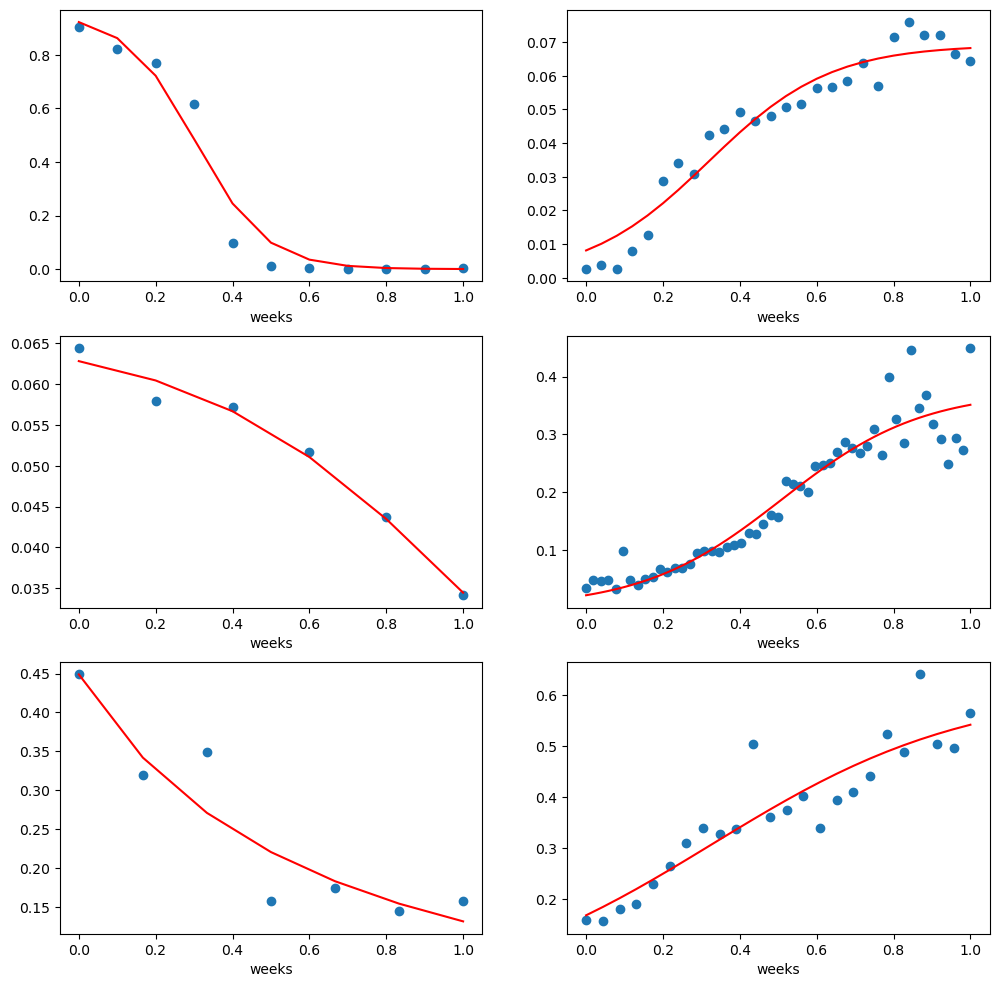

In [138]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
plt.subplot(3,2,1)
plt.scatter(x_days[0], ydata[0], label='[59,70]')
plt.plot(x_days[0], predict[0].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,2)
plt.scatter(x_days[1], ydata[1], label='[70,92]')
plt.plot(x_days[1], predict[1].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,3)
plt.scatter(x_days[2], ydata[2], label='[93,103]')
plt.plot(x_days[2], predict[2].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,4)
plt.scatter(x_days[3], ydata[3], label='[105,150]')
plt.plot(x_days[3], predict[3].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,5)
plt.scatter(x_days[4], ydata[4], label='[151,156]')
plt.plot(x_days[4], predict[4].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,6)
plt.scatter(x_days[5], ydata[5], label='[157,180]')
plt.plot(x_days[5], predict[5].detach().numpy(), 'r-')
plt.xlabel('weeks')

In [139]:
cluster_4

[2, 11, 18, 26, 29, 31, 33]

In [144]:
predict29=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    pre_y=predict[i]*(np.mean(test_before[29])-min_trips)+min_trips
    if i>0:
        pre_y[0]=predict29[i-1][-1]
    predict29.append(pre_y)

Text(0, 0.5, 'Number of trips')

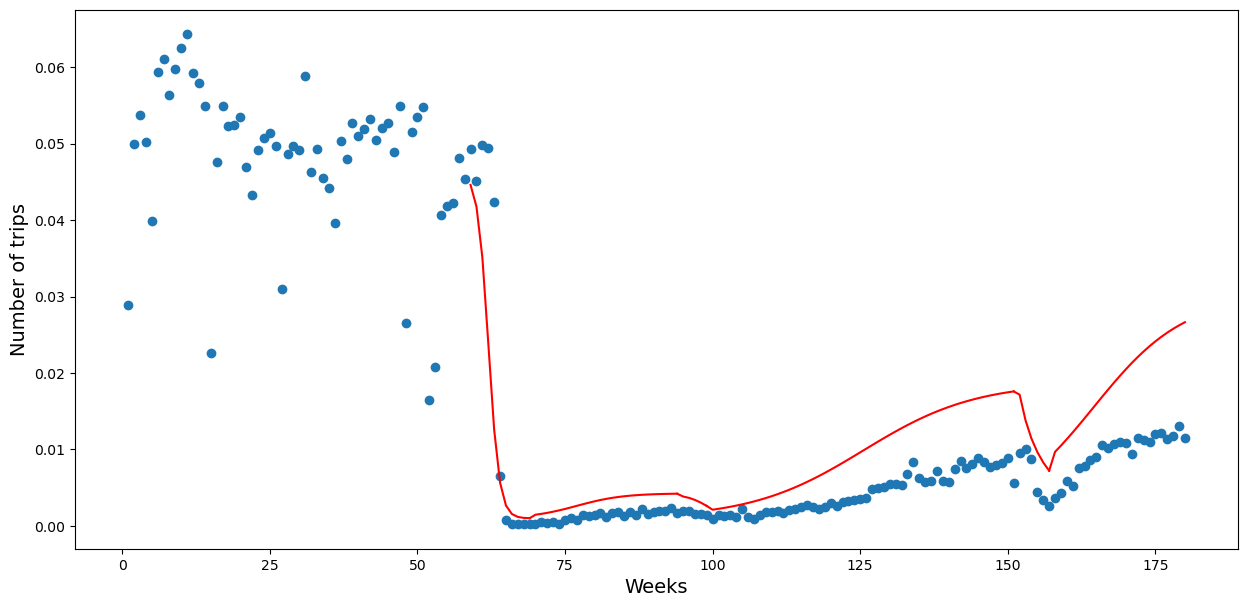

In [145]:
plt.figure(figsize=(15,7))
plt.scatter(np.linspace(1, 180,180), data_test[29][:180],label='real_data')
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    plt.plot(np.linspace(a, b,b-a+1), predict29[i].detach().numpy(),'r')
plt.xlabel('Weeks',fontsize=14)
plt.ylabel('Number of trips',fontsize=14)

In [146]:
predict33=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    pre_y=predict[i]*(np.mean(test_before[33])-min_trips)+min_trips
    if i>0:
        pre_y[0]=predict33[i-1][-1]
    predict33.append(pre_y)

Text(0, 0.5, 'Number of trips')

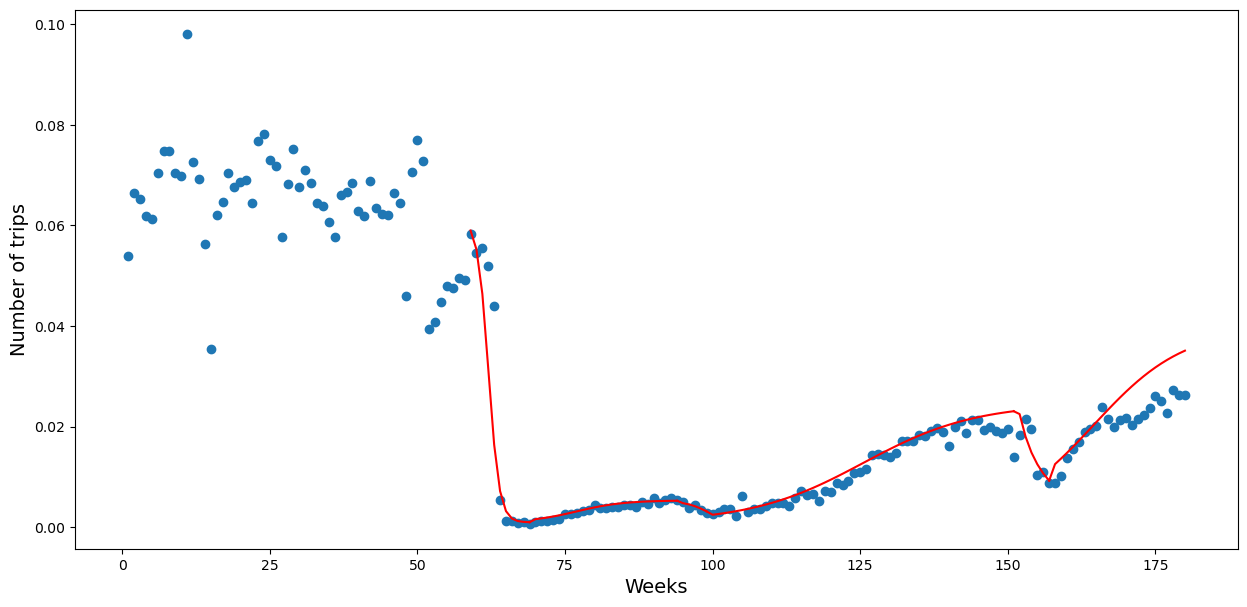

In [147]:
plt.figure(figsize=(15,7))
plt.scatter(np.linspace(1, 180,180), data_test[33][:180],label='real_data')
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    plt.plot(np.linspace(a, b,b-a+1), predict33[i].detach().numpy(),'r')
plt.xlabel('Weeks',fontsize=14)
plt.ylabel('Number of trips',fontsize=14)

In [148]:
predict18=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    pre_y=predict[i]*(np.mean(test_before[18])-min_trips)+min_trips
    if i>0:
        pre_y[0]=predict18[i-1][-1]
    predict18.append(pre_y)

Text(0, 0.5, 'Number of trips')

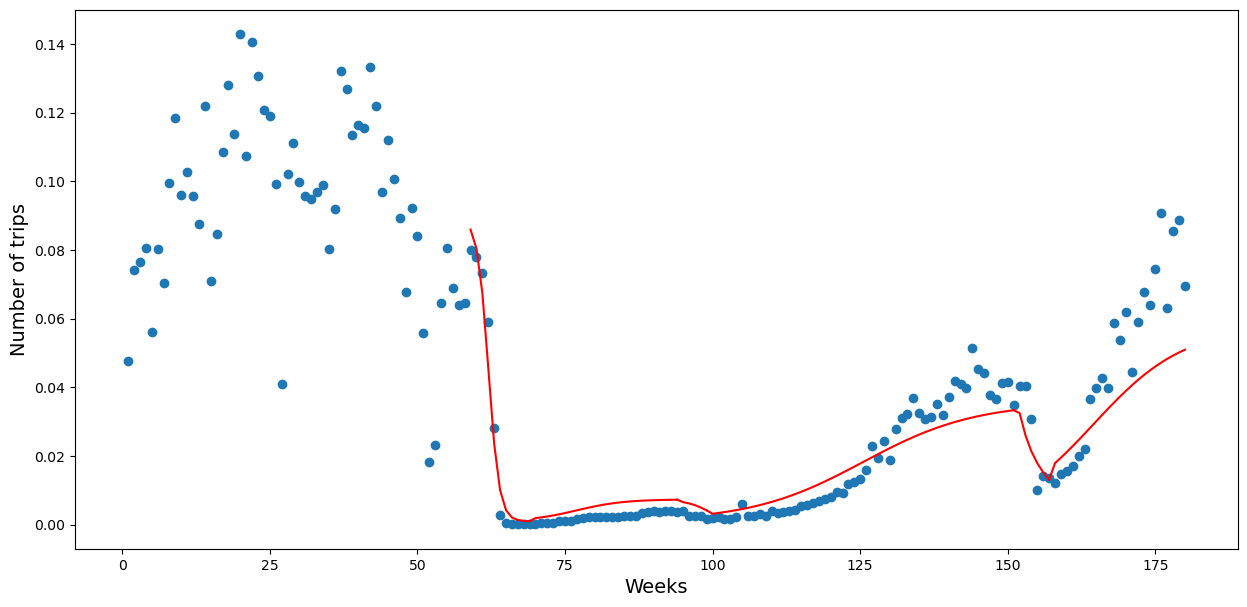

In [149]:
plt.figure(figsize=(15,7))
plt.scatter(np.linspace(1, 180,180), data_test[18][:180],label='real_data')
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    plt.plot(np.linspace(a, b,b-a+1), predict18[i].detach().numpy(),'r')
plt.xlabel('Weeks',fontsize=14)
plt.ylabel('Number of trips',fontsize=14)